In [1]:
import numpy as np
import fitsio
from astropy.table import Table, join, vstack
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.colors as colors
import corner

import seaborn as sb
plt.style.use('seaborn')
sb.set_context("paper", font_scale=1.5)

%load_ext autoreload
%autoreload 2

In [3]:
run = 'y3-merged'
ver = 1.2

match_file = '/project/projectdirs/des/severett/Balrog/{}/stacked_catalogs/{}/sof/balrog_matched_catalog_sof_{}_v{}.fits'.format(run, ver, run, ver)
det_file = '/project/projectdirs/des/severett/Balrog/{}/stacked_catalogs/{}/sof/balrog_detection_catalog_sof_{}_v{}.fits'.format(run, ver, run, ver)

match_cols = ['bal_id', 'true_id', 'meas_cm_mag_deredden',  'true_bdf_mag_deredden', 'true_gap_flux_fwhm4asec', 'meas_gapflux', 'meas_cm_s2n_r']
det_cols = ['bal_id', 'meas_FLAGS_GOLD_SOF_ONLY', 'flags_foreground', 'flags_footprint', 'flags_badregions', 'match_flag_1.5_asec',
            'match_flag_0.5_asec', 'meas_EXTENDED_CLASS_SOF', 'ext_mag']
# sof = sc.BalrogMatchedCatalog(match_file, det_file, match_cols=match_cols, match_type='sof_only', vb=True)

print('Loading matched file...')
match = Table(fitsio.read(match_file, columns=match_cols))
print('Loading det file...')
det = Table(fitsio.read(det_file, columns=det_cols))
print('joining...')
sof = join(match, det, keys='bal_id', join_type='inner')
assert len(match) == len(sof)

# # Match to Ian's DF classifier
# df_file = 'cats/ugriz-mof02-JHK-extcorr_27May20_kNN_class.fits'
# df = Table.read(df_file)
# df.rename_column('id', 'true_id')

# print('Joining with df classifier...')
# sof = join(sof, df, keys='true_id', join_type='left')

# # No match flag or classifier cut!
# cuts = np.where(
#     (sof['meas_FLAGS_GOLD_SOF_ONLY'] < 2) &
#     (sof['flags_foreground'] == 0 ) &
#     (sof['flags_footprint'] == 1) &
#     (sof['flags_badregions'] < 2)
# )

# print('Making cuts...')
# sof = sof[cuts]

Loading matched file...
Loading det file...
joining...


In [4]:
N = len(sof)
print(len(sof[sof['match_flag_1.5_asec'] == 0]) / N)
print(len(sof[sof['match_flag_1.5_asec'] == 1]) / N)
print(len(sof[sof['match_flag_1.5_asec'] == 2]) / N)

0.9658394547254007
0.019862508104946785
0.01429803716965259


In [53]:
sof_file = '/project/projectdirs/des/severett/Balrog/paper-plots/cats/ambiguous-matches_sof.fits' 
print('Writing catalog...')
sof.write(sof_file, overwrite=True)

Writing catalog...


## Load existing catalog

In [2]:
sof_file = '/project/projectdirs/des/severett/Balrog/paper-plots/cats/ambiguous-matches_sof.fits' 
sof = Table.read(sof_file)

In [28]:
print(1. * len(sof[sof['match_flag_1.5_asec'] == 0]) / len(sof))
print(1. * len(sof[sof['match_flag_1.5_asec'] == 1]) / len(sof))
print(1. * len(sof[sof['match_flag_1.5_asec'] == 2]) / len(sof))

0.9666261378159029
0.019255863791582714
0.014117998392514361


## Plots!

In [3]:
def flux2mag(flux, zp=30., clip=0.001):
    return -2.5*np.log10(flux.clip(clip))+zp

In [10]:
plt.rcParams.update({
    'font.family' : 'serif',
    'font.serif' : 'Times', #Palatino, New Century Schoolbook, Bookman, Computer Modern Roman
#     'font.sans-serif'    : Helvetica, Avant Garde, Computer Modern Sans serif
#     'font.cursive'       : Zapf Chancery
#     'font.monospace'     : Courier, Computer Modern Typewriter
    'text.usetex' : True})

0
9639492
1
Cutting on  match_flag_0.5_asec
9565163
2
Cutting on  match_flag_1.5_asec
9503322


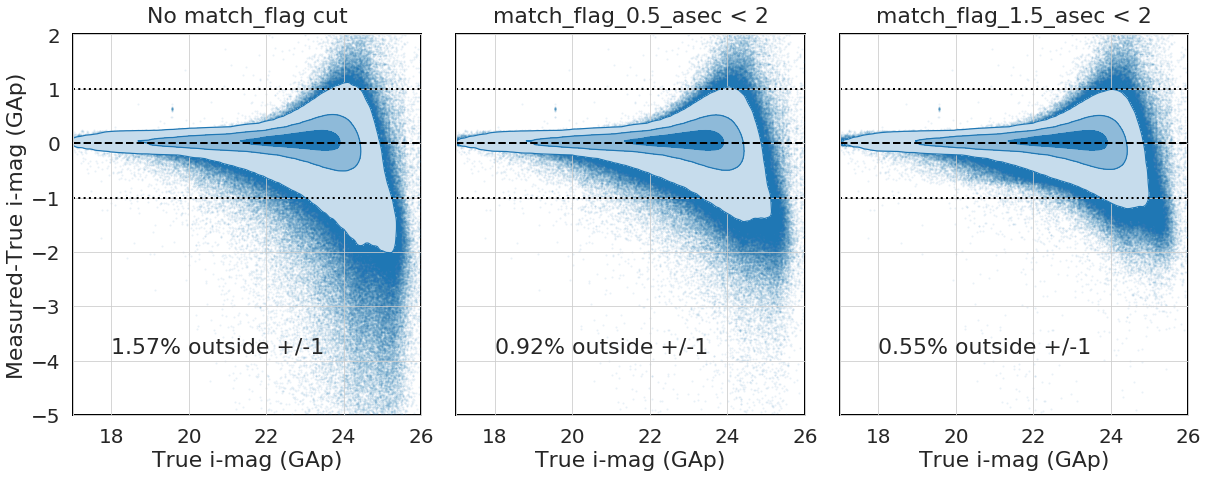

In [5]:
sb.set_style('whitegrid')

plt.rcParams['text.latex.preamble'] = [r'\usepackage[cm]{sfmath}']

SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
fs = 22

# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Palatino"],
# })

xlim = [17, 26]
ylim = [-5, 2]

xlim_c = [17, 26.5]
ylim_c = [-10, 3]

r = (xlim_c, ylim_c)

dl = 1.0
levels = 1.0 - np.exp(-0.5 * np.arange(dl, 3.+dl, dl) ** 2)

b = 'i'
bindx = dict(zip('griz', range(4)))
bi = bindx[b]

f = 1.0
size = int(f * len(sof))

if int(f) == 1:
    sub = sof
else:
    sub = np.random.choice(sof, size, replace=False)

flags = [None, 'match_flag_0.5_asec', 'match_flag_1.5_asec']

fig, axes = plt.subplots(1, 3, sharey=True)

for k in range(3):
    print(k)
    
    flag = flags[k]
    
    x = flux2mag(sub['true_gap_flux_fwhm4asec'][:,bi])
    y = flux2mag(sub['meas_gapflux'][:,bi]) - x   
    
    cuts = (
        (x > xlim_c[0]) &
        (x < xlim_c[1]) &
        (y > ylim_c[0]) &
        (y < ylim_c[1])
#         (sub['meas_cm_s2n_r'] > 10)
    )
        
    if flag is not None:
        print('Cutting on ',flag)
        cuts = np.where( cuts & (sub[flag] < 2) )
    else:
        cuts = np.where(cuts)
        
    x = x[cuts]
    y = y[cuts]
    
    print(len(x))
        
    ax = plt.subplot(1,3,k+1)
    
#     plt.hexbin(x, y, norm=LogNorm(), gridsize=250, cmap='viridis')
    corner.hist2d(x, y, range=r, bins=200, scale_hist=1,
                   plot_datapoints=False, plot_density=False, no_fill_contours=False,
                   fill_contours=True, levels=levels,
                   color='tab:blue', smooth=True, lw=3, alpha=0.01)
    plt.plot(x, y, "o", ms=2, zorder=-1, rasterized=True, alpha=0.1, c='tab:blue', mec='None')
    
#     if k == 0:
#         plt.plot(x[sample['match_flag_1.5_asec']>1], y[sample['match_flag_1.5_asec']>1], "o", ms=2, zorder=-1, rasterized=True, alpha=0.1, c='tab:red', mec='None')
    
    plt.xlabel(r'True i-mag (GAp)')

#     if k == 2:
#         plt.colorbar()
    
    if k > 0:
        plt.setp(ax.get_yticklabels(), visible=False)
    
    plt.axhline(0, lw=2, ls='--', c='k')
    
    thresh = 1
    plt.axhline(-thresh, lw=2, ls=':', c='k')
    plt.axhline(thresh, lw=2, ls=':', c='k')
    outside = 100. * len(y[(y<-thresh) | (y>thresh)])  / len(y)
    
    ax.text(18, -3.85, f'{outside:.2f}% outside +/-{thresh}')

    ax.patch.set_edgecolor('black')  
    ax.patch.set_linewidth('2')  
    
    plt.xlim(xlim)
    plt.ylim(ylim)
    
    pad = 12
    
    if k == 0:
        plt.ylabel(r'Measured-True i-mag (GAp)')
        plt.title('No match_flag cut', pad=pad)
        
    else:
        plt.title(f'{flag} < 2', pad=pad)
    
plt.subplots_adjust(wspace=0.1)
fig.set_size_inches(20, 7)
# fig.tight_layout()

outfile = './figs/ambiguous-matching-panels.pdf'
fig.savefig(outfile, bbox_inches='tight')

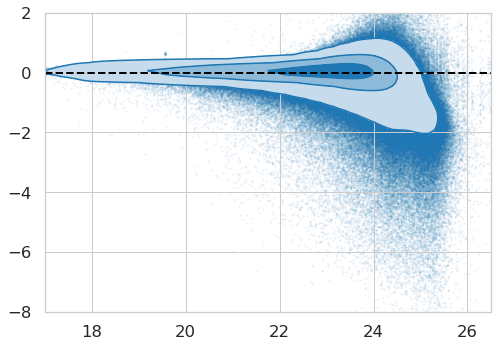

In [44]:
sb.set_style('whitegrid')

xlim = [17, 26.5]
ylim = [-8, 2]

r = (xlim, ylim)

x = flux2mag(sub['true_gap_flux_fwhm4asec'][:,bi])
y = flux2mag(sub['meas_gapflux'][:,bi]) - x

cut = np.where(
    (sub['match_flag_1.5_asec'] < 2) &
    (x > xlim_c[0]) & (x < xlim_c[1]) &
    (y > ylim_c[0]) & (y < ylim_c[1])
)

N = 1

dl = 1.0
levels = 1.0 - np.exp(-0.5 * np.arange(dl, 3.+dl, dl) ** 2)

corner.hist2d(x, y, range=r, bins=75, scale_hist=1,
               plot_datapoints=False, plot_density=False, no_fill_contours=False,
               fill_contours=True, levels=levels,
               color='tab:blue', smooth=True, lw=3, alpha=0.01)
plt.plot(x, y, "o", ms=2, zorder=-1, rasterized=True, alpha=0.1, c='tab:blue', mec='None')

plt.axhline(0, lw=2, ls='--', c='k')

# plt.scatter(x[sub['match_flag_1.5']])

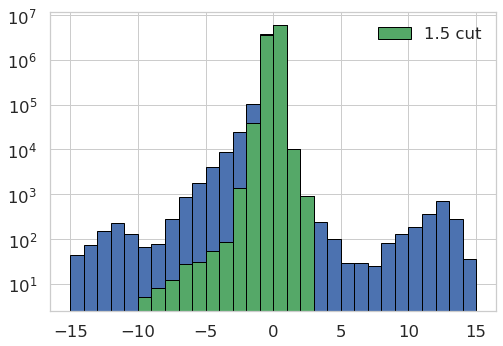

In [47]:
bins = np.arange(-15, 16, 1)
plt.hist(y, ec='k', bins=bins)
plt.hist(y[cut], ec='k', label='1.5 cut', bins=bins)
plt.yscale('log')
plt.legend()

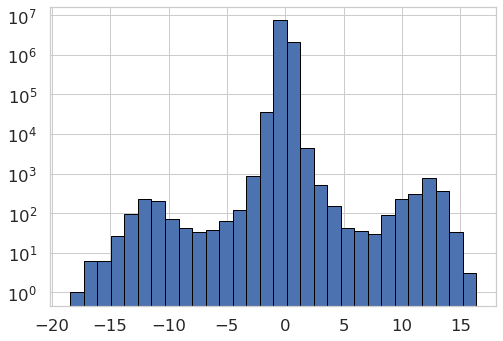

In [35]:
plt.hist(y[cut], bins=30, ec='k')
plt.yscale('log')

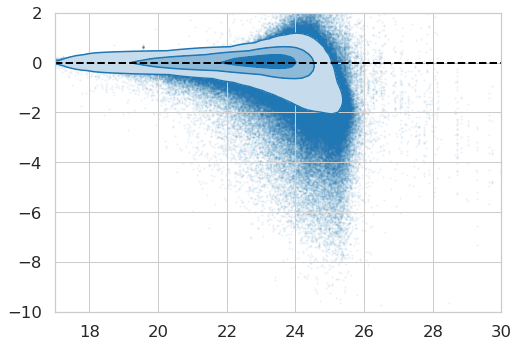

In [39]:
sb.set_style('whitegrid')

xlim = [17, 30]
ylim = [-10, 2]

r = (xlim, ylim)

x = flux2mag(sub['true_gap_flux_fwhm4asec'][:,bi])
y = flux2mag(sub['meas_gapflux'][:,bi]) - x

cut = np.where(sub['match_flag_1.5_asec'] < 2)

N = 1

dl = 1.0
levels = 1.0 - np.exp(-0.5 * np.arange(dl, 3.+dl, dl) ** 2)

corner.hist2d(x, y, range=r, bins=75, scale_hist=1,
               plot_datapoints=False, plot_density=False, no_fill_contours=False,
               fill_contours=True, levels=levels,
               color='tab:blue', smooth=True, lw=3, alpha=0.01)
plt.plot(x, y, "o", ms=2, zorder=-1, rasterized=True, alpha=0.1, c='tab:blue', mec='None')

plt.axhline(0, lw=2, ls='--', c='k')

# plt.scatter(x[sub['match_flag_1.5']])